In [1]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(1)

print("Mevcut kullanılabilir GPU adedi : ", len(tf.config.list_physical_devices('GPU')))

Mevcut kullanılabilir GPU adedi :  1


In [2]:
from keras.datasets import cifar10

# Cifar 10 datasetini yukle

(x_train, y_train), (x_test, y_test) = cifar10.load_data()





In [3]:
import numpy as np

#merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)
print(dataset.shape)
#normalize the images
dataset= dataset.astype("float32")/255
print(dataset.shape)

(60000, 32, 32, 3)
(60000, 32, 32, 3)


In [4]:
BATCH_SIZE = 64

print("Datasetin boyutu : ", dataset.shape)

dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(60000).batch(BATCH_SIZE)
dataset


Datasetin boyutu :  (60000, 32, 32, 3)


<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [5]:
from keras import layers

NOISE_DIM = 1024

generator = keras.models.Sequential(
    [
        layers.InputLayer(input_shape=(NOISE_DIM,)),
        layers.Dense(8 * 8 * 256),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same",activation="LeakyReLU"),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same",activation="LeakyReLU"),
        layers.Conv2DTranspose(3, kernel_size=3, padding="same",activation="sigmoid")

    ]
)

generator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             16793600  
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 3)        3459      
 ranspose)                                                       
                                                        

In [6]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=5, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         819456    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 flatten (Flatten)           (None, 16384)           

In [7]:
optimizerG = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

gAccMetric = keras.metrics.BinaryAccuracy()
dAccMetric = keras.metrics.BinaryAccuracy()

In [8]:
@tf.function
def trainDstep(data):
    batchSize = tf.shape(data)[0]
    noise = tf.random.normal([batchSize, NOISE_DIM])

    y_true = tf.concat([tf.ones((batchSize, 1)), tf.zeros((batchSize, 1))], axis=0)

    with tf.GradientTape() as tape:
        fake = generator(noise)
        x = tf.concat([data, fake], axis=0)
        y_pred = discriminator(x)
        discriminatorLoss = loss_fn(y_true, y_pred)
    
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
    optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

    dAccMetric.update_state(y_true, y_pred)

    return {
        "discriminator_loss": discriminatorLoss,
        "discriminator_accuracy": dAccMetric.result()
    }

In [9]:
@tf.function
def trainGstep(data):
    batchSize = tf.shape(data)[0]
    noise = tf.random.normal([batchSize, NOISE_DIM])

    y_true = tf.ones((batchSize, 1))

    with tf.GradientTape() as tape:
        fake = generator(noise)
        y_pred = discriminator(fake)
        generatorLoss = loss_fn(y_true, y_pred)
    
    grads = tape.gradient(generatorLoss, generator.trainable_weights)
    optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

    gAccMetric.update_state(y_true, y_pred)

    return {
        "generator_loss": generatorLoss,
        "generator_accuracy": gAccMetric.result()
    }



In [10]:
from matplotlib import pyplot as plt

def plotImages(model):
    images = model(np.random.normal(size=(25, NOISE_DIM)))

    plt.figure(figsize=(5, 5))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

    plt.show()

    


E:0, Loss G:0.7433996200561523, Loss D:0.6683954000473022, Acc G:0.022299999371170998, Acc D:0.5445166826248169


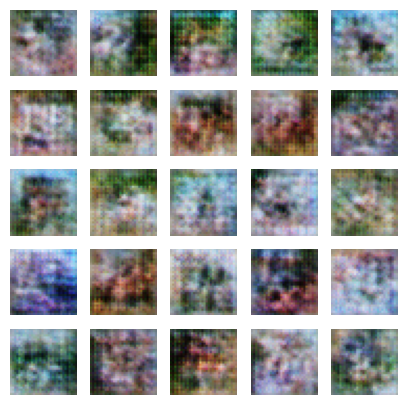

E:1, Loss G:0.8023630380630493, Loss D:0.6700859069824219, Acc G:0.014891666360199451, Acc D:0.5348166823387146


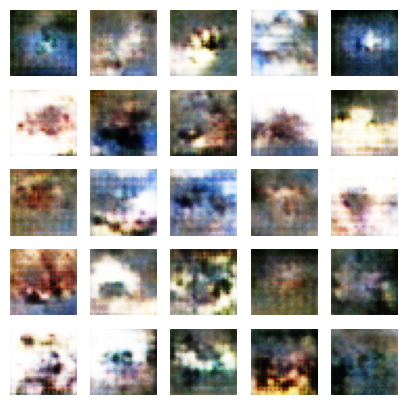

E:2, Loss G:0.8876519799232483, Loss D:0.634762704372406, Acc G:0.01575000025331974, Acc D:0.5388110876083374


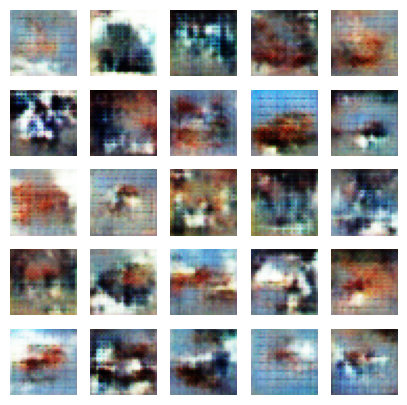

E:3, Loss G:0.8130049109458923, Loss D:0.6909344792366028, Acc G:0.019612500444054604, Acc D:0.5478812456130981


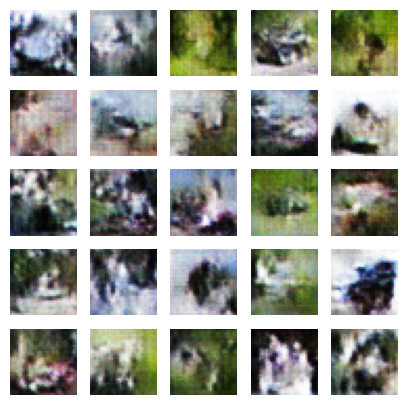

E:4, Loss G:0.8059491515159607, Loss D:0.6674127578735352, Acc G:0.02006666734814644, Acc D:0.5492233037948608


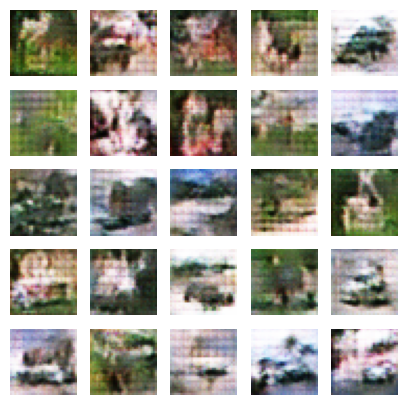

E:5, Loss G:0.7311082482337952, Loss D:0.6858835816383362, Acc G:0.020188888534903526, Acc D:0.5497277975082397


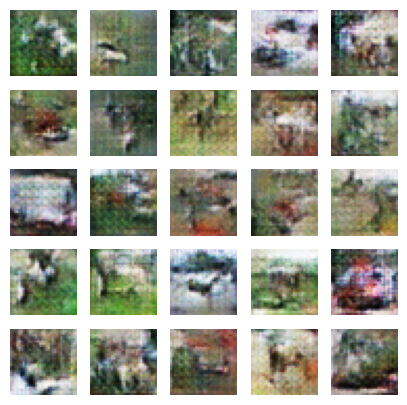

E:6, Loss G:0.9779903888702393, Loss D:0.6510860919952393, Acc G:0.020961904898285866, Acc D:0.5526881217956543


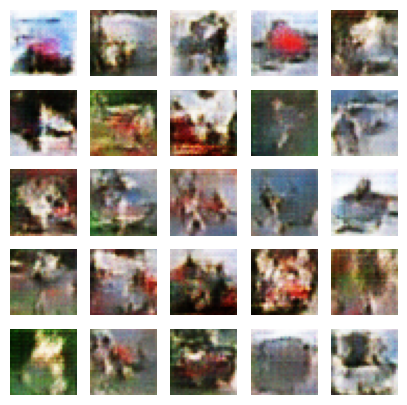

E:7, Loss G:1.0431761741638184, Loss D:0.5906224250793457, Acc G:0.022229166701436043, Acc D:0.5572854280471802


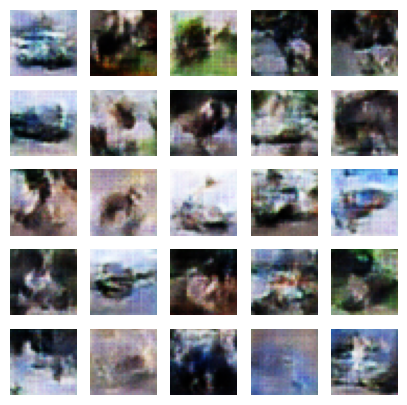

E:8, Loss G:1.0842013359069824, Loss D:0.6514205932617188, Acc G:0.023609260097146034, Acc D:0.5613277554512024


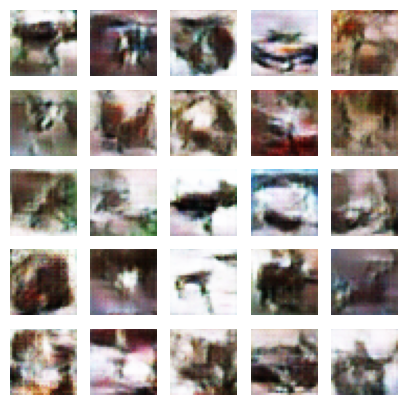

E:9, Loss G:0.8043619990348816, Loss D:0.6834331154823303, Acc G:0.02437666617333889, Acc D:0.5648266673088074


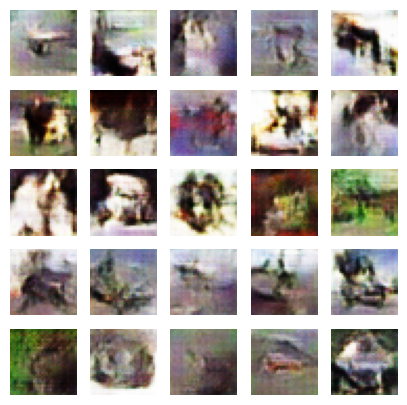

In [11]:
for epoch in range(10):
    dLossSum = 0
    gLossSum = 0
    dAccSum = 0
    gAccSum = 0
    cnt = 0


    for batch in dataset:

        dResult= trainDstep(batch)
        gResult = trainGstep(batch)
        
        # dLossSum += dLoss["discriminator_loss"]
        # gLossSum += gLoss["generator_loss"]
        # dAccSum += dLoss["discriminator_accuracy"]
        # gAccSum += gLoss["generator_accuracy"]
        cnt += 1

    # print("E:{}, Loss G:{}, Loss D:{}, Acc G:{}, Acc D:{}".format(epoch, gLossSum/cnt, dLossSum/cnt, 100*gAccSum/cnt, 100*dAccSum/cnt))
    print("E:{}, Loss G:{}, Loss D:{}, Acc G:{}, Acc D:{}".format(epoch, gResult["generator_loss"], dResult["discriminator_loss"], gResult["generator_accuracy"], dResult["discriminator_accuracy"]))
    
    plotImages(generator)
        
        